Heart Disease in Cleveland
=====
**An analysis by Group 20 DSCI 100 007**

Phoebe McNair-Luxon, Alexandre Beauchemin, Kumaravendhan Ravichandran, Evi Dorsch

Data set source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Introduction
======
Coronary artery disease (CAD) is a heart disease which leads to increased risk of heart attack amongst affected individuals. CAD is caused by plaque buildup - such as cholesterol deposits - in the walls of the heart arteries, which causes partial to complete blockage and reduced blood flow within these blood vessels (Centers for Disease Control and Prevention, 2021; Cleveland Clinic, 2022). To carry out this study, we will be using a mixture of census data and medical data to predict the diagnosis of CAD.

The questions which we are answering with this dataset are as follows: Is it possible to accurately predict CAD from only census data, or only medical data? Is it more accurate to combine both data types in a single model?
The data used to perform this analysis is sourced from the Cleveland Clinic Data of the Heart Disease Data. This data set reports data from 303 patients diagnosed with CAD via an invasive angiogram, coupled with the results of a noninvasive clinical test which could indicate CAD. Patients had no prior evidence of a heart attack or other weaknesses of the heart muscle (Detrano et al., 1989). 

The medical data that were chosen to be included in this analysis are data for blood pressure, cholesterol, blood sugar, and ST depression. The census data that were chosen to be included are age and sex. Blood pressure was included as high blood pressure is a known indicator of CAD. With increasing artery blocking due to CAD, blood pressure increases - a result of blood moving through arteries with higher force. A high systolic blood pressure - arterial pressure during heart beat - is considered to be anything greater than 130 mmHg (Cleveland, 2021). Total cholesterol was included as high levels of cholesterol - specifically low density lipoprotein (LDL) cholesterol - can lead to build up in blood vessel walls, increasing risk of CAD (Centers for Disease Control and Prevention, 2021). Total cholesterol is considered high when it is anything greater than 200 mg/dl (Fletcher, 2023). Blood sugar was included as high fasting blood glucose levels can cause damage to blood vessels and to the nerves which control the heart. High blood sugar is associated with type 2 diabetes, which often results from a sedentary lifestyle and poor diet, all of which predisposes individuals to CAD (Centers for Disease Control and Prevention, 2022). A diabetic fasting blood sugar is considered to be anything over 126 mg/dL (Mount Sinai, 2022). High ST depression (greater than 1mm), indicative of abnormal heart rhythm caused by obstructed blood flow, is also an indicator of CAD (Klabunde, 2023; Froelicher & Myers, 2006). Age was also included as those over 25 years are at higher risk for CAD. (Brown et al, 2022). Additionally, sex was included as individuals of the male sex are at a higher risk of developing CAD (Gheisari, 2020). 

In [1]:
#leading in libraries 
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(readxl)
set.seed(4200)
install.packages("themis")
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Part 1: Data Cleaning and Preliminary  Analysis
=====
**Methods (Cleaning and Wrangling)**

This analysis involves loading and manipulating the data, conducting exploratory data analysis, determining the model accuracy, and producing visualizations based on the predicted data.

The downloaded dataset was initially cleaned and wrangled to prepare it for analysis. This includes removing missing values, converting variables to the correct data types, renaming columns, balancing the data, and splitting the data into training and testing sets. Due to standard practice, the data was split in a 75:25 ratio to provide the model with sufficient data to be trained on. Distribution of CAD diagnosis before and after balancing, and the mean and median of all predictor variables are printed as tibbles. 

To explore the data, summary statistics are calculated for the variables in the dataset. This includes calculating the mean and median for each variable. Histograms showing the distribution of observations in each predictor are then created to better visualize the dataset.


In [2]:
# read in data 
Cl_heart_data <- read.table("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                            sep = ",", col.names = c("age", "sex", "cp", "trestbps", "chol", "fbs",  "restecg", "thalach", 
                                                     "exang", "oldpeak", "slope","ca", "thal", "num"))
#convert from a dataframe to a tibble
Cl_heart_data <- as_tibble(Cl_heart_data)

# convert num from from dbl to factor
Cl_heart_data_2 <- Cl_heart_data |> 
    mutate(num=as_factor(num))

# collapse factor levels returning positive disease diagnosis
Cl_heart_data_2 <-  fct_collapse(Cl_heart_data_2$num,
    "No disease" = "0",
    "Disease" = c("1", "2", "3", "4")) |>
    bind_cols(Cl_heart_data_2)

# rename column
colnames(Cl_heart_data_2) <- c("disease_status", "age", "sex", "cp", "trestbps", "chol", "fbs",  "restecg", 
                               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# select for columns 
clean_heart_data <- Cl_heart_data_2 |>
    select("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "disease_status")

# rename column
colnames(clean_heart_data) <- c("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "num")

# count number of observations for disease and no disease for use in next cell
count_before_balancing <- count(clean_heart_data, num)

# balance data
ups_recipe <- recipe(num ~ ., data = clean_heart_data) |>
  step_upsample(num, over_ratio = 1, skip = FALSE) |>
  prep()

clean_heart_data <- bake(ups_recipe, clean_heart_data)

# count number of observations for disease and no disease for use in next cell
count_after_balancing <- count(clean_heart_data, num)

#splitting data into training and testing sets
heart_data_split <-  initial_split(clean_heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_data_split)
heart_test <- testing(heart_data_split)
# head(heart_train)
# head(heart_test)

#create new data frame without num for calculating stats
heart_train_1 <- heart_train |>
    select(-num)

# visualizing the data (only training data)
names <- c("Mean", "Median")
mean_1 <- heart_train_1 |>
    map_df(mean, na.rm = TRUE)
median_1 <- heart_train_1 |>
    map_df(median, na.rm = TRUE)
tbl1 <- bind_rows(mean_1, median_1)
exploratory_analysis <- bind_cols(names, tbl1)

#calcualte number of rows in training dataset
number_of_rows <- heart_train |>  
    nrow()

New names:
• `` -> `...1`
New names:
• `` -> `...1`


In [3]:
#bind the two counts and label data with human readable names
count_data <- bind_cols(count_before_balancing, count_after_balancing) |>
    select(-num...3)
titles<- c("Disease Status", "Before Balancing", "After Balancing")
colnames(count_data) <- titles
count_data

New names:
• `num` -> `num...1`
• `n` -> `n...2`
• `num` -> `num...3`
• `n` -> `n...4`


Disease Status,Before Balancing,After Balancing
<fct>,<int>,<int>
No disease,164,164
Disease,139,164


**Table 1: Distribution of observations in the entire data set before and after balancing.** The data set consisted of 46% healthy patients and 54% patients with heart disease. This is not heavily skewed - however, balancing was employed to ensure the best accuracy; after which the distribution was 50% healthy and 50% with heart disease. 

In [4]:
#print counts 
print("Number of Rows for all variables in training data set: (no NA values)")
number_of_rows

#print means and medians 
exploratory_analysis

[1] "Number of Rows for all variables in training data set: (no NA values)"


[1] 246

...1,age,sex,trestbps,chol,fbs,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mean,54.87805,0.6707317,133.2886,249.8333,0.1585366,1.054472
Median,55.50000,1.0000000,130.0000,245.0000,0.0000000,0.800000


**Table 2: Summary statistics**: Mean and Median of all variables used in predictions of heart disease from the 246 total observations. By visual inspection, no NA values were found in any of the parameters used. 

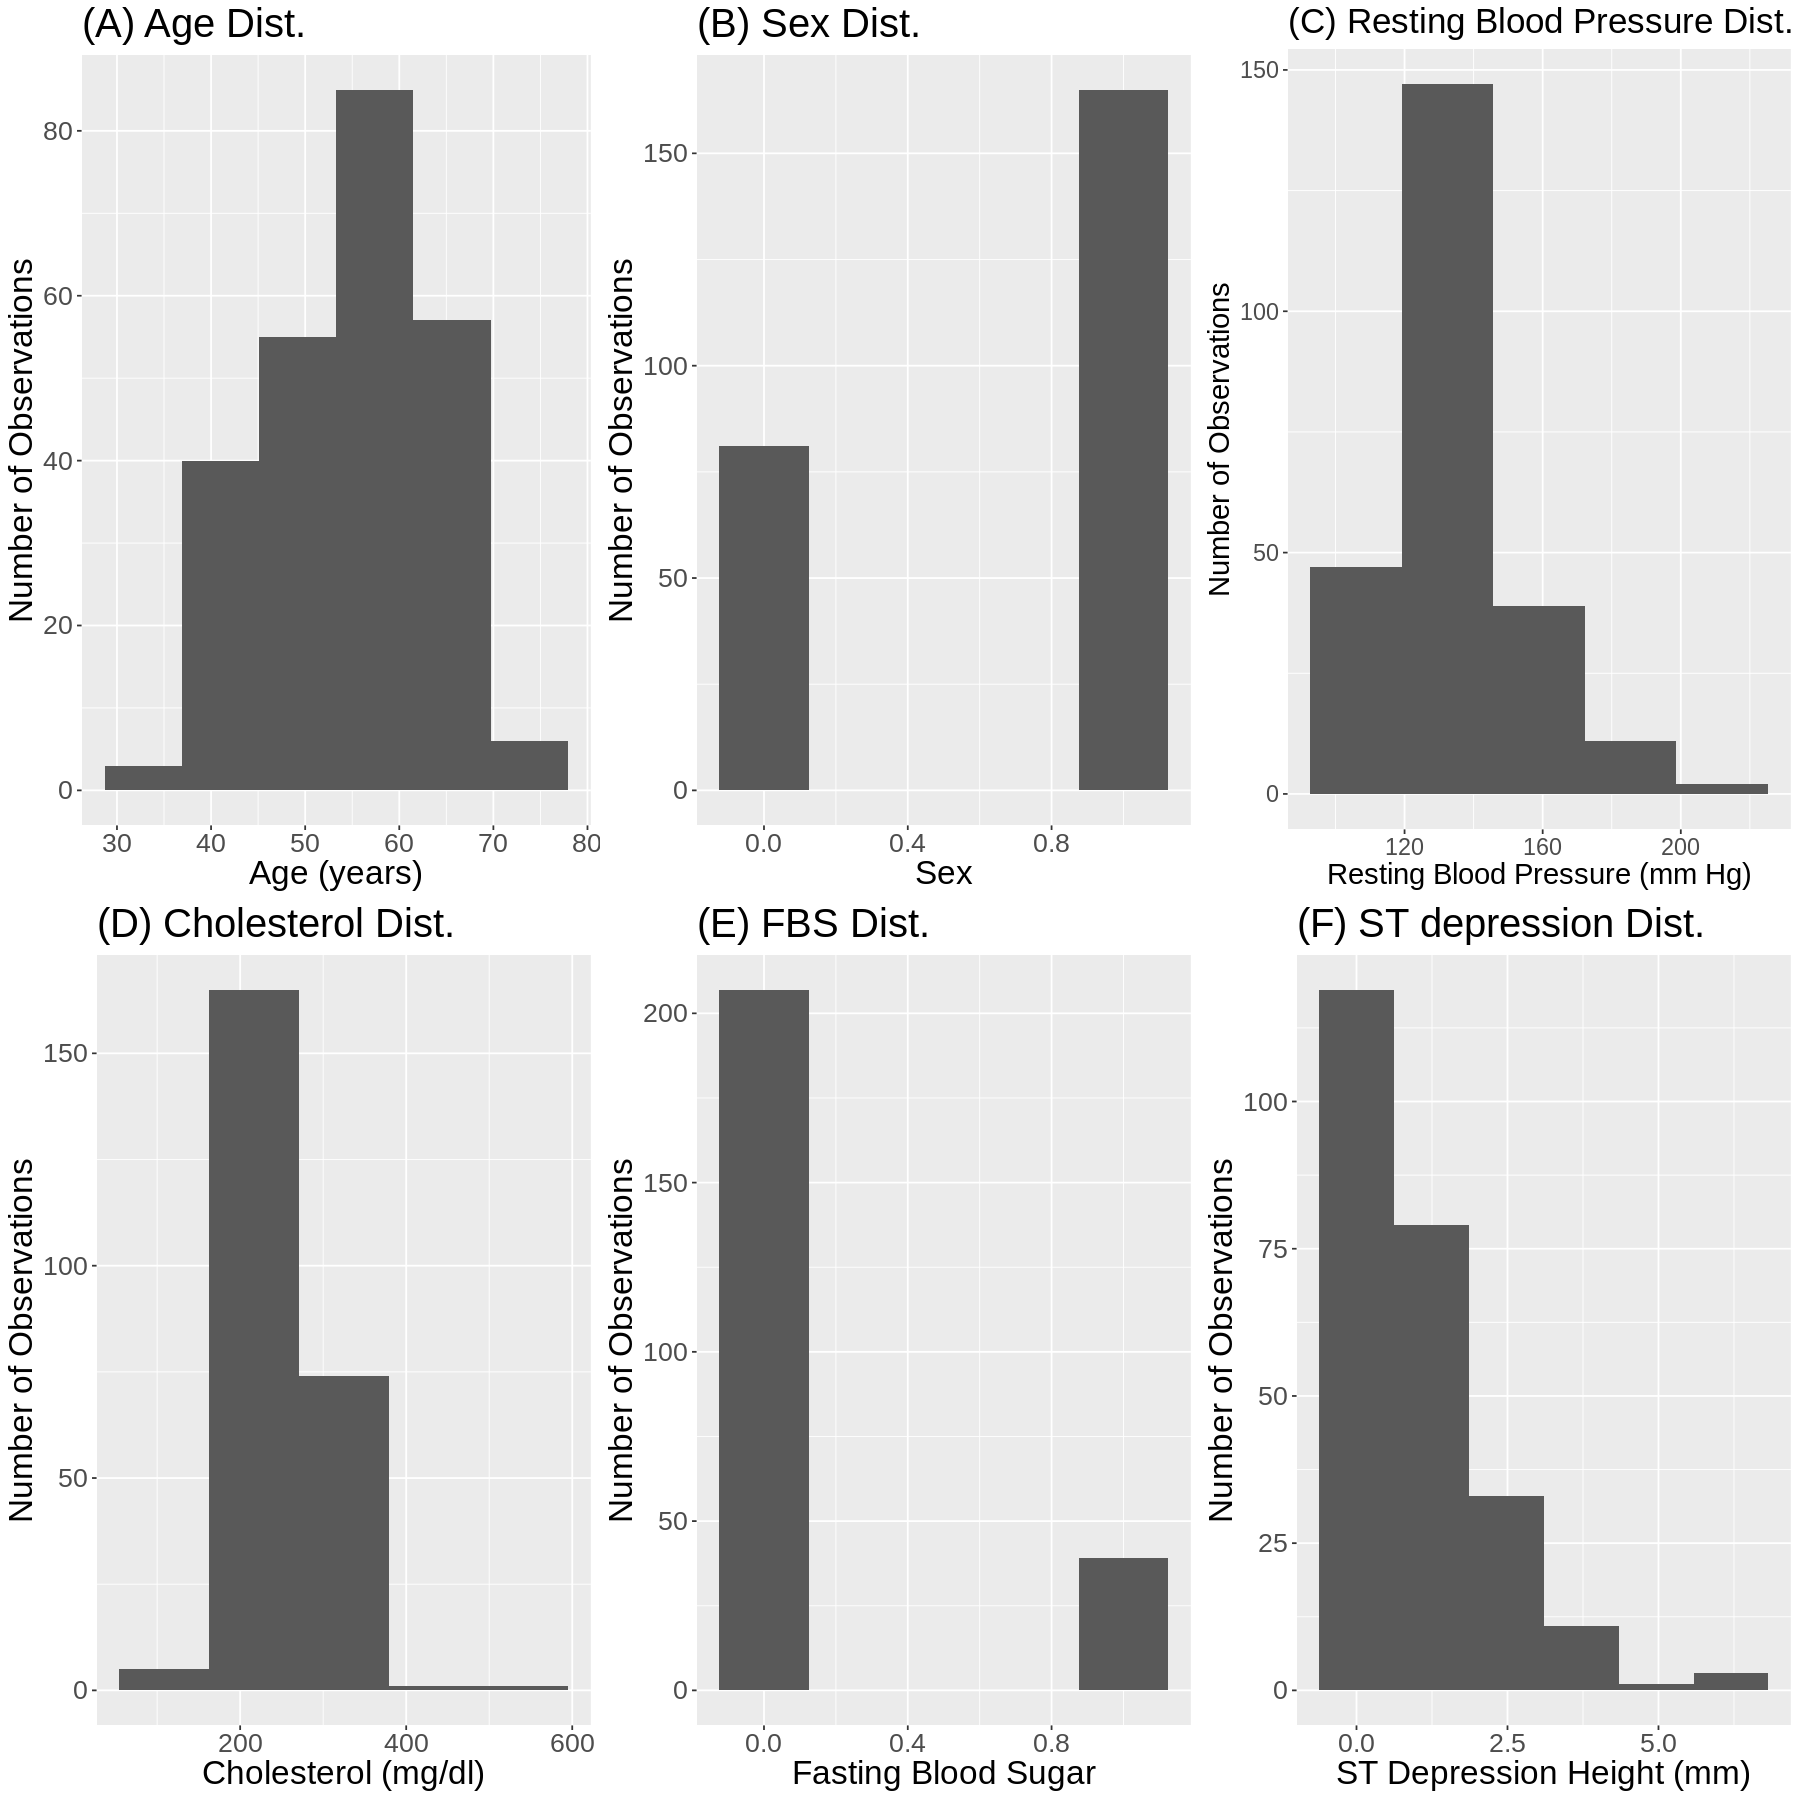

In [5]:
options(repr.plot.height = 15, repr.plot.width = 15)

# Visulize data distribution in a graph
age_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 6, aes(x=age)) +
    labs(x="Age (years)",y = "Number of Observations") +
    ggtitle("(A) Age Dist.") +
    theme(text=element_text(size=20))

sex_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 5, aes(x=sex)) +
    labs(x="Sex",y = "Number of Observations") +
    ggtitle("(B) Sex Dist.") +
    theme(text=element_text(size=20))

trestbps_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 5,aes(x=trestbps)) +
    labs(x="Resting Blood Pressure (mm Hg)",y = "Number of Observations") + 
    ggtitle("(C) Resting Blood Pressure Dist.") +
    theme(text=element_text(size=17.5))

chol_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 5,aes(x=chol)) +
    labs(x="Cholesterol (mg/dl)",y = "Number of Observations") +
    ggtitle("(D) Cholesterol Dist.")+
    theme(text=element_text(size=20))

fbs_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 5 ,aes(x=fbs)) +
    labs(x="Fasting Blood Sugar",y = "Number of Observations") +
    ggtitle("(E) FBS Dist.") +
    theme(text=element_text(size=20))

oldpeak_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 6,aes(x=oldpeak)) +
    labs(x="ST Depression Height (mm)",y = "Number of Observations") +
    ggtitle("(F) ST depression Dist.") +
    theme(text=element_text(size=20))

#arrange all graphs to print together
grid.arrange(age_distribution,sex_distribution,trestbps_distribution, chol_distribution,
             fbs_distribution, oldpeak_distribution, ncol =3)


**Figure 1: Distribution of data within each variable.** Individual graph shows the distribution of data within the variable, with several observations on the y-axis. Each variable has 303 observations (n=303). Bin size is dependent on variables as all data is non-scaled at this point. Note: Dist. means Distribution and all mean and median data are derived from Table 2 (below). **(A)** Age Distribution. Age is distributed normally with most patients being between 50 and 60, and few patients under 30 or over 70. The mean age of this population is 55 and the median is 56, supporting a normal distribution. **(B)** Sex Distribution. If the patient’s sex is female they are assigned a value of 0, if their sex is male they are assigned a value of 1. About ⅔ of the patients are of the male sex. **(C)** Rest Blood Pressure: Blood pressure has a slightly positively skewed distribution. The mean of the systolic blood pressure was 132.38mmHg, the median is 130mmHg.  **(D)** Cholesterol Distribution: Cholesterol is slightly positively skewed. The mean is 247.65mg/dl, the median is 244 mg/dl. **(E)** FBS Distribution. If the patient has a FBS greater than 120 mg/dl they are assigned a variable of 1, if the FBS is less than this they are assigned 0. About 90% of the patients have FBS under 120 mg/dl. **(F)**  ST Depression Distribution: The ST depression is positively skewed. The mean is 1.08mm, and the median is 0.80mm.

Part 2: Running the Analysis
=====
**Methods (Creating the Classification Models)**

First, the data from relevant predictors were selected and incorporated into a recipe with the `tune()` function. The `workflow()` and `nearest_neighbor()` functions were then used in conjunction with a 5 fold cross validation on the training data to test K values ranging from 1 to 10 and produce a plot of Accuracy vs K values. This range of K values was chosen as the k value is usually below 20 for data sets of size 100-1000, and this data set contains 303 entries. This plot was then used to determine the best K value.

Next this K value was used to build a classification model using the `nearest_neighbor()` and `workflow()` functions. The accuracy of this model was then evaluated using the testing data. Comparing the predicted classes to the actual classes in the testing set allows for estimates of each model’s accuracy. 
This process was then performed for a census-data-only model, a medical-data-only model, and a mixed-data model including both categories of predictors. 

Finally, a confusion matrix with Truth and Prediction values of diagnosis was created to calculate the percentage of observations that are false positives and false negatives for each model.

Analysis with Census Data
-----

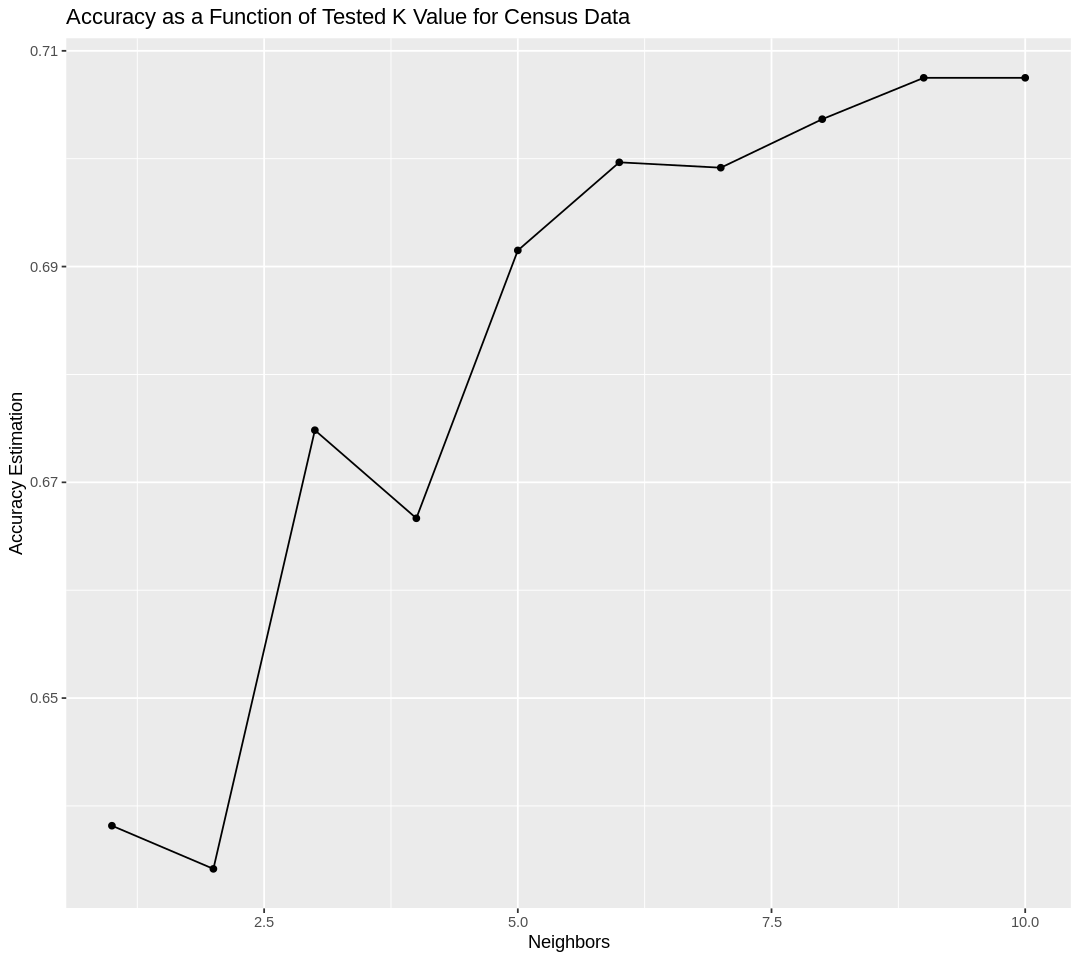

In [6]:
#Analysis with just Census Data
#Analysis with all Paremeters
set.seed(4200)
options(repr.plot.height = 8, repr.plot.width = 9)
#select relevant parameters
heart_train_census <- heart_train |>
    select("age", "sex", "num")
heart_test_census <- heart_test |>
    select("age", "sex", "num")

#make recipe with tune() function
heart_recipe_census <- recipe(num ~ ., data = heart_train_census) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#make a vfold
heart_vfold_census <- vfold_cv(heart_train_census, v =5, strata = num)

#make a tuning spec 
heart_spec_tune_census <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make tibble of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#collect metrics 
heart_workflow_census <- workflow() |>
       add_recipe(heart_recipe_census) |>
       add_model(heart_spec_tune_census)|>
       tune_grid(resamples = heart_vfold_census, grid = k_vals) 

accuracies_census <- heart_workflow_census |>
       collect_metrics() |> #sum of the SD and the mean 
       filter(.metric == "accuracy")

#plot the accuracies
accuracy_vs_k_census <- ggplot(accuracies_census, aes(x = neighbors, y= mean)) +
       geom_point() +
       geom_line() +
        labs(x= "Neighbors", y = "Accuracy Estimation") +
        ggtitle("Accuracy as a Function of Tested K Value for Census Data")
accuracy_vs_k_census

#at this point we evaluate the accuracy of the model below to choose the best K

**Figure 2: Plot of Accuracies as a Function of Tested K value for Census Data.** Testing K values ranging from 1 to 10, in increments of 1, the accuracy fluctuated between 0.63 and 0.695. The highest accuracy was 0.695 at a K value of 9, so this K value was used to run the classification on the Census Data. 

In [7]:
#We now create a model using the best K chosen from above
set.seed(4200)
#make a new spec 
heart_spec_census <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

#make a new workflow (retrain mdoel) 
heart_fit_census <- workflow() |>
    add_recipe(heart_recipe_census) |>
    add_model(heart_spec_census) |>
    fit(data = heart_train_census)

#predict the accuracy of prediction while only using medical predictors
heart_predicted_census <- predict(heart_fit_census, heart_test_census) |>
    bind_cols(heart_test_census)

#produce the accuracy of prediction while only using census predictors
acc_census <- heart_predicted_census |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
tibble(acc_census)

#create a confusion matrix with Truth and Prediction values of diagnosis
confusion_census <- heart_predicted_census|>
             conf_mat(truth = num, estimate = .pred_class)
confusion_census

#Calculate the percentage wrong predictions that are false positive
false_positive_census <- 18/82

#Calculate the percentage wrong predictions that are false negative
false_negative_census <- 7/82

#Produce a tibble with false_positive and false_negative values
tibble(false_positive_census, false_negative_census)

acc_census
<dbl>
0.695122


            Truth
Prediction   No disease Disease
  No disease         23       7
  Disease            18      34

false_positive_census,false_negative_census
<dbl>,<dbl>
0.2195122,0.08536585


**Table 3: Classification Model Based on Predictors Derived from Census Data Accuracy and Percent of False Positive and False Negative Predictions.** The overall accuracy of this model was 69.5% correct predictions, leaving 30.5% of predictions incorrect. 21.9% of predictions were false positives (predicted disease where there was none), and 8.5% of predictions were false negatives (predicted no disease where there was disease). 

Analysis with just Medical Data
-----

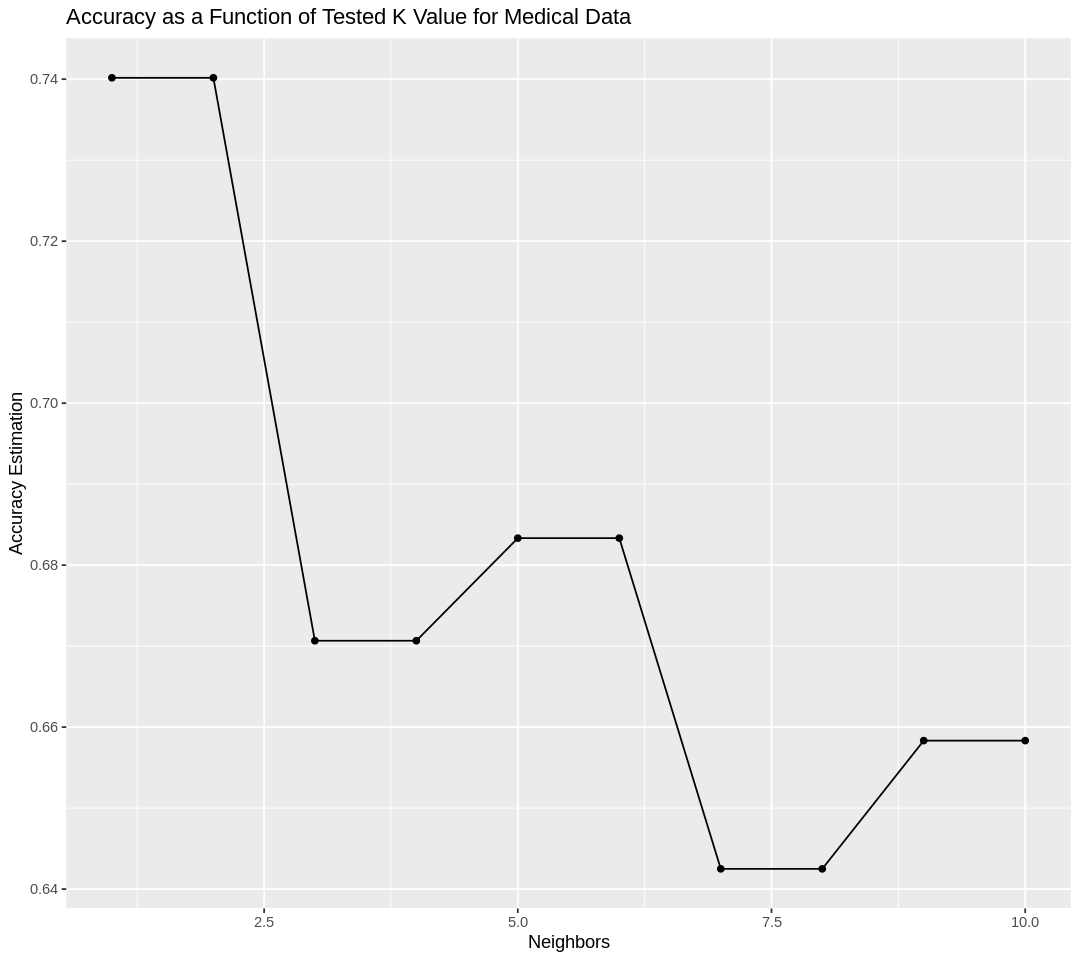

In [8]:
#Analysis with just Medical Data
#Analysis with all Paremeters
set.seed(4200)
options(repr.plot.height = 8, repr.plot.width = 9)
#select relevant parameters
heart_train_med <- heart_train |>
    select("trestbps", "chol", "fbs", "oldpeak", "num")
heart_test_med <- heart_test |>
    select("trestbps", "chol", "fbs", "oldpeak", "num")

#make recipe with tune() function
heart_recipe_med <- recipe(num ~ ., data = heart_train_med) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#make a vfold
heart_vfold_med <- vfold_cv(heart_train_med, v =5, strata = num)

#make a tuning spec 
heart_spec_tune_med <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make tibble of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#collect metrics 
heart_workflow_med <- workflow() |>
       add_recipe(heart_recipe_med) |>
       add_model(heart_spec_tune_med)|>
       tune_grid(resamples = heart_vfold_med, grid = k_vals) 

accuracies_med <- heart_workflow_med |>
       collect_metrics() |> #sum of the SD and the mean 
       filter(.metric == "accuracy")

#plot the accuracies
accuracy_vs_k_med <- ggplot(accuracies_med, aes(x = neighbors, y= mean)) +
       geom_point() +
       geom_line() +
      labs(x= "Neighbors", y = "Accuracy Estimation") +
         ggtitle("Accuracy as a Function of Tested K Value for Medical Data")
accuracy_vs_k_med

#at this point we evaluate the accuracy of the model below to choose the best K

**Figure 3: Plot of Accuracies as a Function of Tested K value for Medical Data.** Testing K values ranging from 1 to 10, in increments of 1, the accuracy fluctuated between 0.642 and 0.73. The highest accuracy was 0.73 at a K value of 2, so this K value was chosen as the K used for running the classification on the Medical Data. 

In [9]:
#We now create a model using the best K chosen from above
set.seed(4200)
#make a new spec 
heart_spec_med <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

#make a new workflow (retrain mdoel) 
heart_fit_med <- workflow() |>
    add_recipe(heart_recipe_med) |>
    add_model(heart_spec_med) |>
    fit(data = heart_train_med)

#predict the accuracy of prediction while only using medical predictors
heart_predicted_med <- predict(heart_fit_med, heart_test_med) |>
    bind_cols(heart_test_med)

#create a confusion matrix with Truth and Prediction values of diagnosis
confusion_med <- heart_predicted_med|>
             conf_mat(truth = num, estimate = .pred_class)

#produce the accuracy of prediction while only using medical predictors
acc_med <- heart_predicted_med |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
as_tibble(acc_med)
confusion_med

#Calculate the percentage wrong predictions that are false positive
false_positive_med <- 13/82

#Calculate the percentage wrong predictions that are false negative
false_negative_med <- 9/82

#Produce a tibble with false_positive and false_negative values
tibble(false_positive_med, false_negative_med)

value
<dbl>
0.7317073


            Truth
Prediction   No disease Disease
  No disease         28       9
  Disease            13      32

false_positive_med,false_negative_med
<dbl>,<dbl>
0.1585366,0.1097561


**Table 4: Classification Model Based on Predictors Derived from Medical Data Accuracy and Percent of False Positive and False Negative Predictions.** The overall accuracy of this model was 73.1% correct predictions, leaving 26.8% of predictions incorrect. 15.8% of predictions were false positives (predicted disease where there was none), and 10.9% of predictions were false negatives (predicted no disease where there was disease). 

Analysis with All Parameters
----

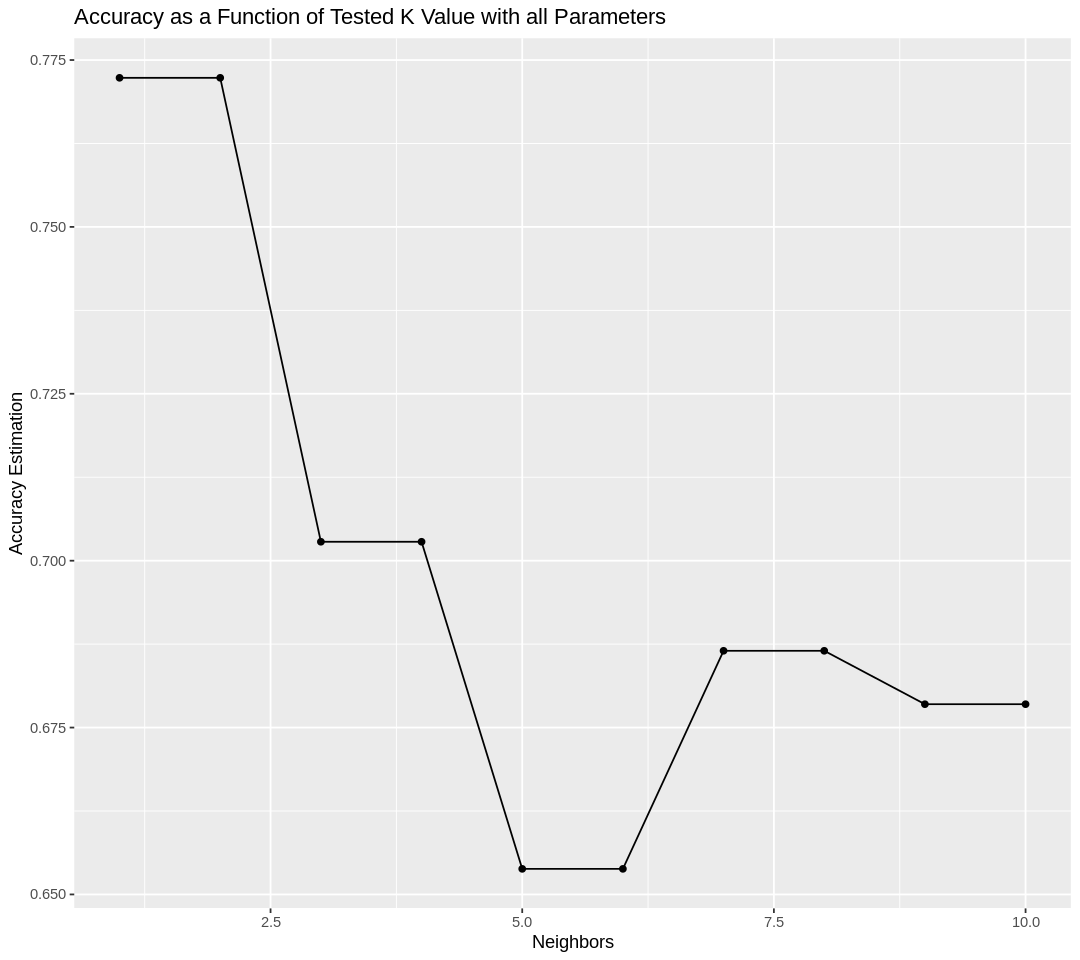

In [10]:
#Analysis with all Paremeters
set.seed(4200)
options(repr.plot.height = 8, repr.plot.width = 9)

#select relevant parameters
heart_train_all <- heart_train |>
    select("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "num")
heart_test_all <- heart_test |>
    select("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "num")

#make recipe with tune() function
heart_recipe_all <- recipe(num ~ ., data = heart_train_all) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#make a vfold
heart_vfold_all <- vfold_cv(heart_train_all, v =5, strata = num)

#make a tuning spec 
heart_spec_tune_all <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make tibble of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#collect metrics 
heart_workflow_all <- workflow() |>
       add_recipe(heart_recipe_all) |>
       add_model(heart_spec_tune_all)|>
       tune_grid(resamples = heart_vfold_all, grid = k_vals) 

accuracies_all <- heart_workflow_all |>
       collect_metrics() |> #sum of the SD and the mean 
       filter(.metric == "accuracy")

#plot the accuracies
accuracy_vs_k_all <- ggplot(accuracies_all, aes(x = neighbors, y= mean)) +
       geom_point() +
       geom_line() +
      labs(x= "Neighbors", y = "Accuracy Estimation") +
         ggtitle("Accuracy as a Function of Tested K Value with all Parameters")
accuracy_vs_k_all

#at this point we evaluate the accuracy of the model below to choose the best K

**Figure 4: Plot of Accuracies as a Function of Tested K value for All Parameters.** Testing K values ranging from 1 to 10, in increments of 1, the accuracy fluctuated between 0.65 and 0.77. The highest accuracy was 0.77 at a K value of 2, so this K value was chosen as the K used for running the classification on the data that included all parameters.

In [11]:
#We now create a model using the best K chosen from above
set.seed(4200)
#make a new spec 
heart_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

#make a new workflow (retrain mdoel) 
heart_fit_all <- workflow() |>
    add_recipe(heart_recipe_all) |>
    add_model(heart_spec_all) |>
    fit(data = heart_train_all)

# predict the accuracy of prediction while only using medical predictors
heart_predicted_all <- predict(heart_fit_all, heart_test_all) |>
    bind_cols(heart_test_all)

# produce the accuracy of prediction while only using medical predictors
acc_all <- heart_predicted_all |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
as_tibble(acc_all)

#create a confusion matrix with Truth and Prediction values of diagnosis
confusion_all <- heart_predicted_all|>
             conf_mat(truth = num, estimate = .pred_class)
confusion_all

#Calculate the percentage wrong predictions that are false positive
false_positive_all <- 13/82

#Calculate the percentage wrong predictions that are false negative
false_negative_all <- 6/82

#Produce a tibble with false_positive and false_negative values
tibble(false_positive_all, false_negative_all)

value
<dbl>
0.7682927


            Truth
Prediction   No disease Disease
  No disease         28       6
  Disease            13      35

false_positive_all,false_negative_all
<dbl>,<dbl>
0.1585366,0.07317073


**Table 5: Classification Model Based on Predictors Derived from All Predictors Accuracy and Percent of False Positive and False Negative Predictions.** The overall accuracy of this model was 76.8% correct predictions, leaving 23.2% of predictions incorrect. 15.8% of predictions were false positives (predicted disease where there was none), and 7.3% of predictions were false negatives (predicted no disease where there was disease).

Visualizing the Models
----

**Methods (Visulizing the Results)**

To visualize the estimated accuracies of each predictor type, the accuracy values for all three models (All, Census, and Medical) were first combined into a single data frame using the `bind_cols` function. Then the `pivot_longer` function was used to tidy the data frame into a long format, where the accuracy values were in a single column and the predictor type was in another column. We then created a bar graph of the accuracy values using the `ggplot` function and `geom_bar` layer. The x-axis was labeled with the predictor type, the y-axis with the accuracy, and the fill with the predictor type. The y-axis limits were set to be between 0 and 1. Using the same methods, a grouped bar graph was created to provide a visual comparison of the accuracy, false positive predictions and false negative predictions for each model. 

The combination model that incorporates both medical and census factors has the highest accuracy for determining whether a patient has coronary artery disease (CAD) or not. When choosing a model for clinical application, it's crucial to take the false positive and false negative rates into account.


In [12]:
#bind all of the accuracies together 
accuracy_data <- bind_cols(acc_census,acc_med, acc_all) 
names <- c("Census_Accuracy","Medical_Accuracy", "All_Accuracy")
colnames(accuracy_data) <- names

#tidy the accuracy data (make in tidy format) 
tidy_accuracy_data <- pivot_longer(accuracy_data, 
            cols = Census_Accuracy:All_Accuracy, 
            names_to = "data_set", 
            values_to = "accuracy")
tidy_accuracy_data                     

New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`


data_set,accuracy
<chr>,<dbl>
Census_Accuracy,0.6951220
Medical_Accuracy,0.7317073
All_Accuracy,0.7682927


**Table 6: Numerical Report of Accuracy of each Classification Model.** Census_Accuracy refers to the model including only the predictors drawn from census data, Medical_Accuracy refers to the model including only the predictors drawn from Medical Data, All_Accuracy refers to the model that includes all parameters. *Note: Medical vs Census variables defined in Introduction.* The accuracy for the model including all parameters was the highest at 77% accurate, while the model using only the Census data resulted in the lowest accuracy at 69.5% accurate.

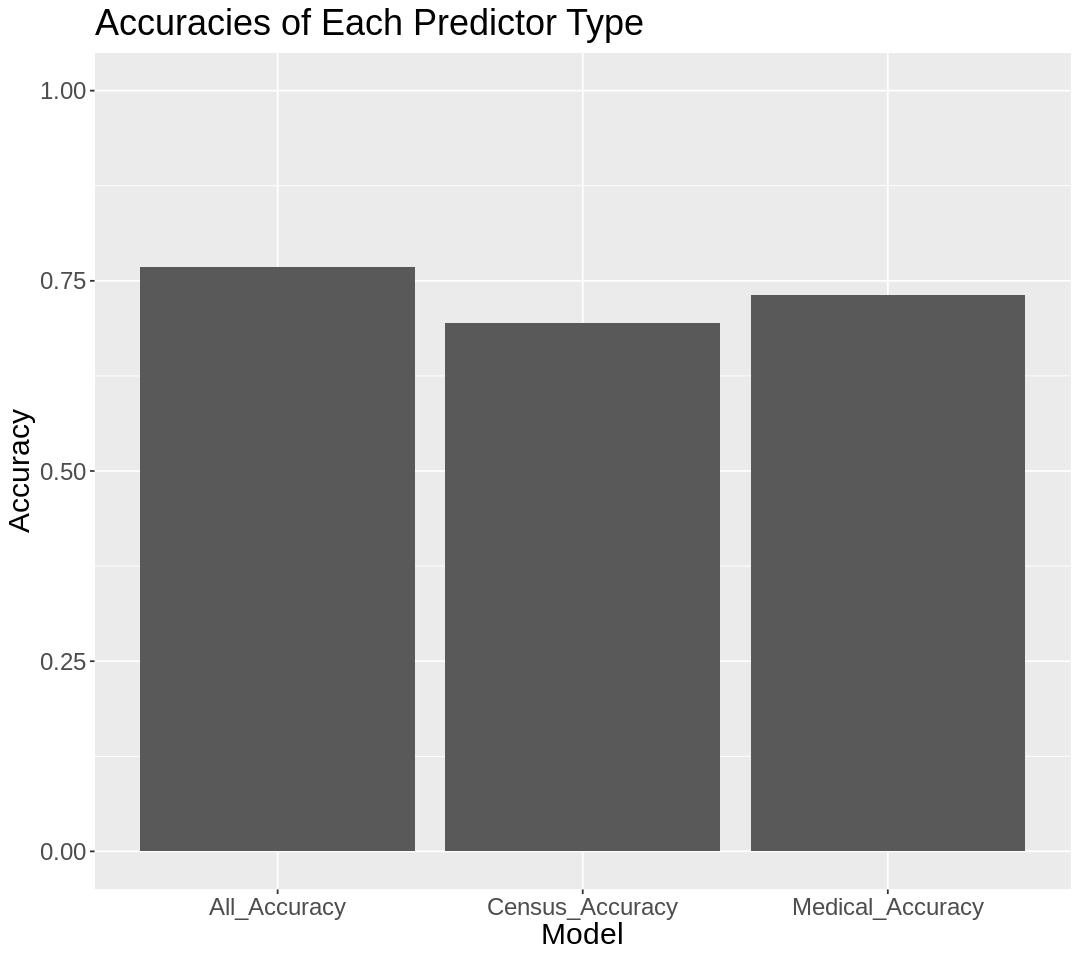

In [24]:
#plot the accuracies as a bar graph
Accuracy_plot <- tidy_accuracy_data |>
    ggplot(aes(x = data_set, y=accuracy)) +
    geom_bar(stat = "identity") +
    labs(x= "Model", y="Accuracy") +
    ylim(0:1) +
    ggtitle("Accuracies of Each Predictor Type") +
    theme(text=element_text(size=18))
Accuracy_plot

**Figure 5: Bar Graph of Accuracies of each Classification Model** Census_Accuracy refers to the model including only the predictors drawn from census data, Medical_Accuracy refers to the model including only the predictors drawn from Medical Data, All_Accuracy refers to the model that includes all parameters. Accuracy (y-axis) is the percentage of predictions made with correct outcomes (either disease or no disease). The model using all predictor types had the highest accuracy, while the model using only the census data had the lowest accuracy. 

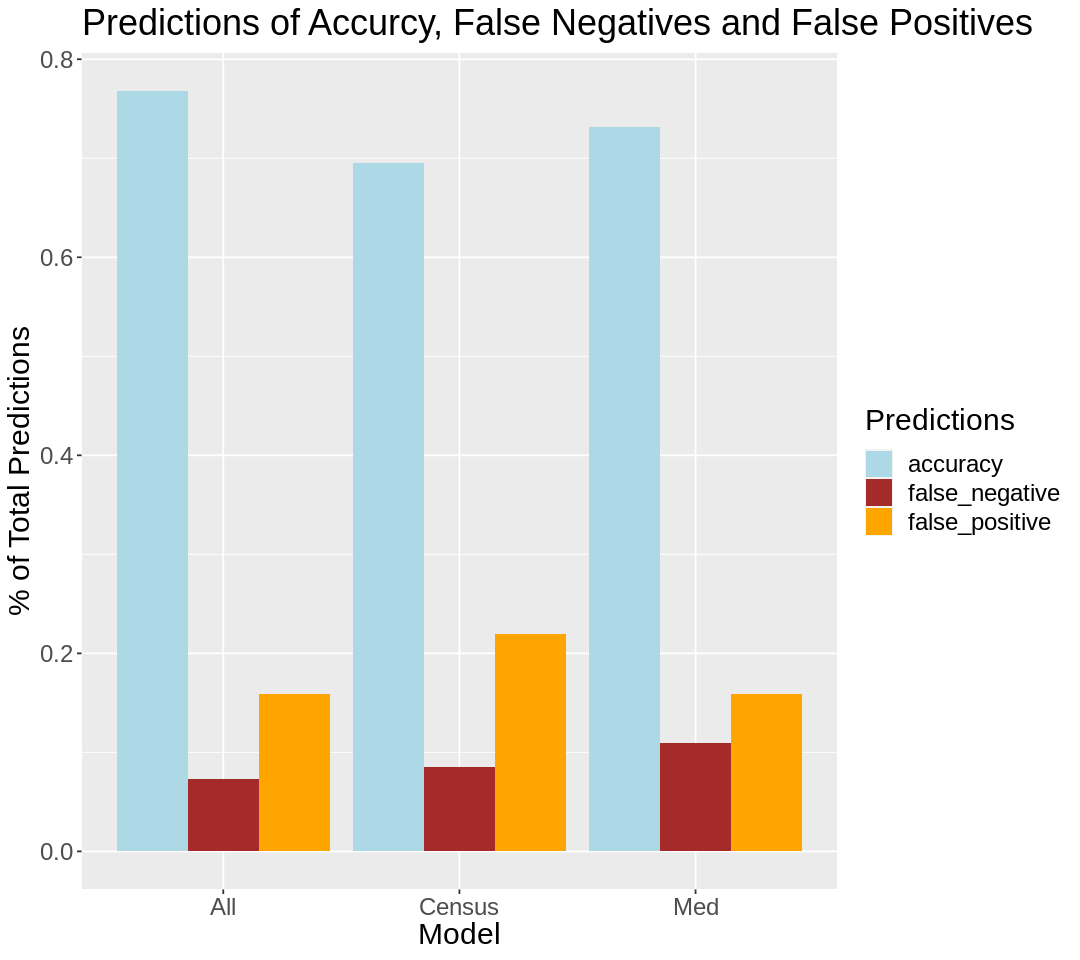

In [18]:
#Create a data frame with accuraxy, false_positive and false_negative values for each type of predictors
error_df <- data.frame(
  model = c("All", "Census", "Med"),
  accuracy = c(acc_all,acc_census, acc_med),
  false_positive = c(false_positive_all, false_positive_census, false_positive_med),
  false_negative = c(false_negative_all, false_negative_census, false_negative_med))

#Modify the data frame to use it to plot bar graph
error_long <- tidyr::gather(error_df, key = "metric", value = "value", -model)

# Create the grouped bar chart
ggplot(error_long, aes(x = model, y = value, fill = metric)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Model", y = "% of Total Predictions", fill = "Predictions")+
  ggtitle("Predictions of Accurcy, False Negatives and False Positives") +
    theme(text=element_text(size=18)) +
    scale_fill_manual(values = c("light blue", "brown", "orange"))

 **Figure 6: Bar Graph of Accuracies of each Classification Model including rates of False Positive and False Negatives.** Census refers to the model including only the predictors drawn from census data, Med refers to the model including only the predictors drawn from Medical Data, All refers to the model that includes all parameters. Accuracy is the percentage of predictions of the right outcome. False_negative is the percentage of total predictions that predicted no disease where there was a disease, while false_positive is the percentage of total predictions that predicted disease where there was no disease. The model using all predictors had the highest accuracy, as well as the lowest rate of false positives, most importantly the lowest rate of false negatives. The model using only census data had a similar rate of false negatives to the model using all parameters, however, the overall accuracy of the model using only census data was worse.

Discussion
====

Using the Cleveland Clinic Heart Disease dataset it was first aimed to predict CAD with medical data, then census data, and then both, in order to assess which model most accurately predicts CAD. It was found that medical and census data used jointly were the most accurate at predicting CAD within individuals who had come in for medical testing after being referred to a cardiologist; this model had an accuracy of prediction of 76.8%. This means that 23.3% of predictions were incorrect. Of these, 15.8% of predictions were false positives (a predicted disease where there was none) and 7.3% were false negatives (predicted no disease where there was disease). The model using only medical data had an accuracy of 73.1%, meaning that 26.8% of predictions were incorrect. Of these 15.8% of predictions were false positives and 10.9% were false negatives. False negatives are of particular importance, as affected individuals being misdiagnosed as not having CAD would not be seeking the required care. The model using only census data had the worst accuracy of 69.5%, meaning that 30.5% of the predictions were incorrect. Of these, 21.9% were false positives and 8.5% of predictions were false negatives. 

It can be concluded that it is crucial to consider both census and medical data when diagnosing someone with CAD (using non-invasive tests) using this model. It is however important to understand that this model can only be extrapolated to a population of individuals who are already under suspicion of being affected by CAD - usually highlighted by intermediate disease prevalence and chest pain syndromes - akin to the patients in the Cleaveland data set. 

Overall, it was expected that the combined model would be most accurate in CAD diagnosis prediction, and this was the case. However, both the census and medical data were also able to predict CAD diagnosis to a more limited extent. Overall, neither of the three models has a high estimated accuracy of prediction. Incorrectly diagnosing people with CAD could be devastating, primarily due to the side effects of going on medications for CAD (NYU Langone Health, n.d.). Therefore, the gold standard of coronary angiography for CAD diagnosis may be most beneficial until more accurate and less invasive methods of diagnosis emerge. 

It was initially stipulated this analysis could be used to assess whether census data could be used to provide accurate prediction models for CAD risk across a population, thus rendering diagnosis and screening for CAD more efficient. The census data model by itself is not sufficient to predict CAD diagnosis due to its relatively low accuracy. However, it could be useful in predicting populations that are at higher risk of CAD (and therefore would benefit from more testing as a preventative measure). Overall, this classification analysis should lead to further investigation into which predictors most accurately predict CAD diagnosis, and how to use those findings to reduce the invasiveness of medical screening tests currently used to assess for CAD.

Ultimately, this brings up the question of whether the model built through this project is reliable enough to be used in any way - as its high inaccuracy could lead to impactful mis-diagnoses. Therefore, it may be worth investigating other ways to improve upon diagnosis and treatment. Possibly, it would also be worth researching preventative treatments that could be applied to any at-risk individuals, indifferent to CAD diagnosis status.  Alternatively, research into more effective - while simultaneously less invasive - methods of CAD diagnosis could also result in better patient outcomes, as existing methods are invasive (angiography) or not as accurate (other testing methods). 

References
---

American Heart Association, Inc. (2021, May 4). Cardiovascular Disease and Diabetes. https://www.heart.org/en/health-topics/diabetes/diabetes-complications-and-risks/cardiovascular-disease--diabetes 

Brown, J., Gerhandt, T., & Kwon, E. (2022). Risk Factors For Coronary Artery Disease. StatPearls Publishing. 

Cleveland Clinic. (2022, August 18). Coronary Artery Disease. https://my.clevelandclinic.org/health/diseases/16898-coronary-artery-disease 

Cleave Clinic. (2021, September 21). High Blood Pressure (Hypertension). https://my.clevelandclinic.org/health/diseases/4314-hypertension-high-blood-pressure 

Centers for Disease Control and Prevention. (2021, July 19). Coronary Artery Disease. https://www.cdc.gov/heartdisease/coronary_ad.htm 

Centers for Disease Control and Prevention. (2022, June 20). Heart Disease. https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html 

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J.J., Sandhu., Guppy, K.H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. Am J Cardiol, 64 (5), 304-310. https://doi.org/10.1016/0002-9149(89)90524-9

Fletcher, J. (2023, March 31). What should my cholesterol level be at my age? MedicalNewsToday. https://www.medicalnewstoday.com/articles/315900 


Froelicher, V., & Myers, J. (2006). CHAPTER seven - Diagnostic Application of Exercise Testing, Exercise and the Heart (2nd ed., pp. 191-248). Elsevier Inc. https://doi.org/10.1016/B978-1-4160-0311-3.X5001-3  

Gheisari, F., Emami, M., Shahraki, H.R., Samipour, S., & Nematollahi, P. (2020). The Role of Gender in the Importance of Risk Factors for Coronary Artery Disease. Cardiol Res Pract, Article 6527820.  https://doi.org/10.1155/2020/6527820
 
Klabunde, R. (2023, January 30). Electrophysiological Changes During Cardiac Ischemia. Cardiac Physiology Concepts. https://www.cvphysiology.com/CAD/CAD012 

NYU Langone Health. (n.d.). Medication for Coronary Artery Disease. https://nyulangone.org/conditions/coronary-artery-disease/treatments/medication-for-coronary-artery-disease#:~:text=Side%20effects%20are%20usually%20mild,doctor%20before%20stopping%20the%20medication. 

Mount Sinai. (2022,  January 9). Blood sugar test-blood.  https://www.mountsinai.org/health-library/tests/blood-sugar-test-blood. 